# k-Means

El algoritmo de k-means o k-medias es un método de agrupamiento basado en las vecindades de los datos vistos como puntos en un espacio vectorial.

El método busca estimar las medias de los clústers de tal forma que la varianza de estas medias sea mínima; de tal forma que los grupos o clústers obtenidos contengan puntos parecidos entre sí, en donde la similitud se basa en la cercanía bajo una métrica de espacio vectorial.

In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from operator import itemgetter
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

El algoritmo de $k$-medias se basa en los siguientes pasos:

1. Se generan centroides (medias) de manera aleatoria.
2. Los puntos del dataset se agrupan en el clúster, $\hat{c}$, cuya media es la más cercana; esto es: $$\hat{c} = \arg\min_j ||x-\mu_j||^2$$
3. Se recalculan las medias con base en los puntos que pertenecen a su clúster. Esto es: $$\mu_j = \frac{1}{|\hat{c}|} \sum_{x \in \hat{c}} x$$
4. Se repiten los pasos 2 y 3 hasta que no se hagan más reasignaciones de las medias.

In [2]:
class kMeans():
    """
    Clase que define el método de k-medias.
    """
    def __init__(self, n_clusters=2, init='random'):
        #Número de clústers
        self.n_clusters = n_clusters
        #Clústers vectores
        self.clusters = defaultdict(list)
        #Clústers con nombres
        self.named_clusters = defaultdict(list)
        #Centroides
        self.centroids = None
        #Inicialización
        self.init = init
        
    def fit(self, X, names=None):
        """
        Aprende las medias/centroides adecuados dados los datos no-supervisados.
        """
        #Inicialización de parámetros
        if self.init == 'data':
            C = X[np.random.choice(X.shape[1], self.n_clusters)]
        if self.init == 'random':
            C = np.random.uniform(np.min(X),np.max(X), size=(self.n_clusters, X.shape[1]))
        #Paro
        stop = False
        while stop == False:
            #Cálculo de distancias con respecto a c
            dists = np.array([np.linalg.norm(X-c, axis=1) for c in C])
            #Cluster más cercano
            clusts = np.argmin(dists,axis=0)
            #Clusterización de los datos
            if names != None:
                data = names
            else:
                data = [i for i in range(X.shape[0])]
            for k,v,n in zip(clusts,X,data):
                self.clusters[k].append(v)
                self.named_clusters[k].append(n)
                
            #Actualización de C
            new_c = np.array([sum(vecs)/len(vecs) for clas, vecs in self.clusters.items()])
            
            #Criterio de paro
            if C.all() == new_c.all():
                stop = True
                self.centroids = C
            else:
                #Actualización de parámetros
                C = new_c

### Aplicación del algoritmo

Para probar el algoritmo generamos datos aleatorios en $\mathbb{R}^2$ en base a una distribución normal. Estos datos pertenecerían a dos clústers.

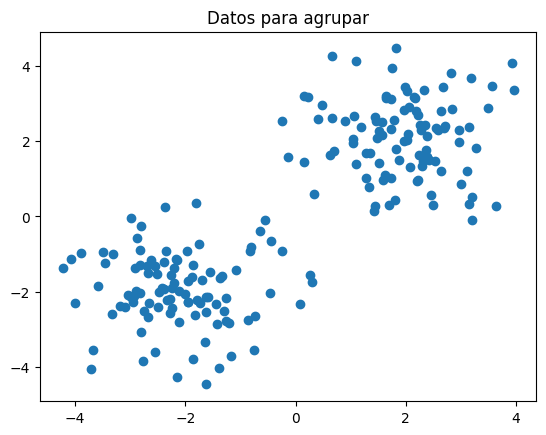

In [3]:
#Generación de datos aleatorios para agrupar
group1 = np.random.normal(-2,1,size=(100,2))
group2 = np.random.normal(2,1,size=(100,2))
X = np.concatenate((group1, group2))

#Visualización de los datos
plt.scatter(X[:,0], X[:,1])
plt.title('Datos para agrupar')
plt.show()

Ahora generamos el modelo y determinamos los clústers en base a los datos.

In [4]:
#Generación del modelo
model = kMeans(n_clusters=2)
#Estimación de los clusters
model.fit(X)

Podemos entonces visualizar cuáles son los grupos que se estiman con base en el algoritmo de k-means. Visualizamos también los centroides/medias que son los puntos en los que se basan los clústers.

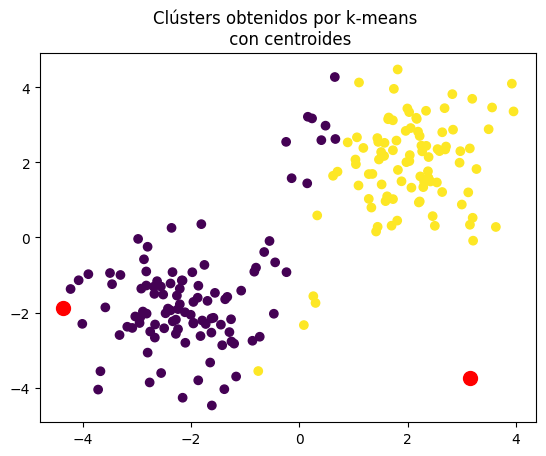

In [5]:
#Obtención del clúster para cada dato
clusters = np.zeros(X.shape[0])
for c, points in model.named_clusters.items():
    for x in points:
        clusters[x] = c

#Visualización de los clústers con centroides
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.scatter(model.centroids[:,0], model.centroids[:,1], c='red', s=100)
plt.title('Clústers obtenidos por k-means \n con centroides')
plt.show()

Finalmente, podemos visualizar las distribuciones que generan las medias o centroides. Estas son distribuciones normales.

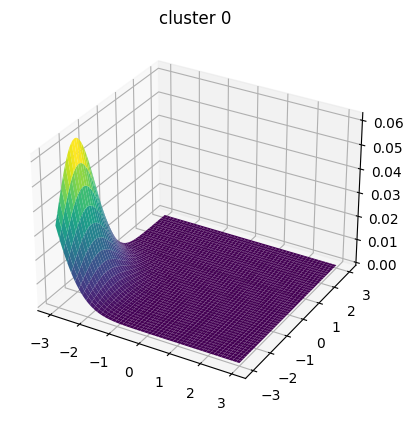

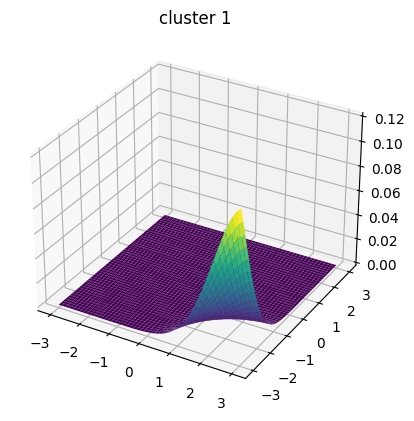

In [6]:
def plot_dist(mu):
    """
    Función para visualizar las distribuciones.
    """
    #Distribución normal
    a = np.linspace(-3,3,500)
    b = np.linspace(-3,3,500)
    A, B = np.meshgrid(a,b)
    pos = np.empty(A.shape + (2,))
    pos[:, :, 0] = A; pos[:, :, 1] = B
    rv = multivariate_normal(mu) #, np.dot(desv.T,desv))

    #Ploteo
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(A, B, rv.pdf(pos),cmap='viridis',linewidth=0)

#Visualización de las distribuciones
for i in range(model.n_clusters):
    plot_dist(model.centroids[i])
    plt.title('cluster '+str(i))
    plt.show()

### Evaluación

La evaluación en el agrupamiento, al ser no-supervisado, no es sencilla, pues se requeriría de una especie de supervisión para poder comparar la calidad de los clústers.

En este caso usamos un gold standard; es decir, un agrupamiento que consideraríamos óptimo para los puntos. Este gold standard está con base en la forma en que generamos los datos, pero en general depende de los resultados esperados.

Para evaluar utilizamos la pureza, definida como:

$$\mathrm{purity} = \frac{1}{N} \sum_i \max_j |c_i \cap \hat{c}_j|$$

In [7]:
gold_standard = [[i for i in range(0,100)],[j for j in range(100,200)]]

purity = 0.0
for j, c in model.named_clusters.items():
    purity += (1./X.shape[0])*np.max([len(set(c).intersection(set(gold_c))) for gold_c in gold_standard])
    
print(purity)

0.935
